# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import cv2
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten,TimeDistributed, BatchNormalization, Activation, Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l1,l2

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [6]:
# Defining Hyperparameters
rows = 120   # X
cols = 120   # Y
channel = 3  # number of channels in images 3 for color(RGB)
frames=10

In [7]:
# Image resizing - such that we have all the images in a specific size
def cropResize(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = resize(img, (rows,cols))
    return resized_image

In [8]:
# Plot t view the training and validation accuracy
def plot(history):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =  np.round(np.linspace(0,29,frames)).astype(int)
    print(len(img_idx))

    while True:
        t = np.random.permutation(folder_list)
        x = len(img_idx)
        y = 120
        z = 120
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,rows,cols,channel))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # cropping the images, image_cropped = image[80:360,30:360,:]
                    # crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = cropResize(image)
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                #print(batch_labels.shape)
                #print(batch_labels)
            yield batch_data, batch_labels

        # code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
             print("Batch: ",num_batches+1,"Index:", batch_size)
             batch_size = len(folder_list) - (batch_size*num_batches)
             batch_data = np.zeros((batch_size,frames,rows,cols,channel))
             batch_labels = np.zeros((batch_size,5))
             for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #image_cropped =image[80:360,30:360,:]
                    image_resized = cropResize(image)
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                #print(batch_labels.shape)
        yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs= 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# 1. Conv3D

In [11]:
model_conv3d = Sequential()

model_conv3d.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(frames,rows,cols,channel)))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(32, (2, 2, 2), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(64, (2, 2, 2), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(128, (2, 2, 2), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))

#Flatten Layers
model_conv3d.add(Flatten())

model_conv3d.add(Dense(128, activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Dropout(0.5))
model_conv3d.add(Dense(128, activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Dropout(0.25))

#softmax layer
model_conv3d.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam() #write your optimizer
model_conv3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3d.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 10, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 10, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 60, 60, 32)     4128      
                                                                 
 batch_normalization_1 (Batc  (None, 5, 60, 60, 32)    1

2024-10-31 01:15:33.329810: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-31 01:15:33.329882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history_conv3d = model_conv3d.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
10
Epoch 1/30


2024-10-31 01:16:01.433460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.6304 - categorical_accuracy: 0.3922Source path =  /home/datasets/Project_data/val ; batch size = 10
10

Epoch 00001: val_loss improved from inf to 3.60678, saving model to model_init_2024-10-3101_15_29.137681/model-00001-1.63037-0.39216-3.60678-0.16000.keras
67/67 [==============================] - 74s 1s/step - loss: 1.6304 - categorical_accuracy: 0.3922 - val_loss: 3.6068 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.9268 - categorical_accuracy: 0.2985
Epoch 00002: val_loss improved from 3.60678 to 2.28436, saving model to model_init_2024-10-3101_15_29.137681/model-00002-1.92683-0.29851-2.28436-0.32000.keras
67/67 [==============================] - 25s 375ms/step - loss: 1.9268 - categorical_accuracy: 0.2985 - val_loss: 2.2844 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.9285 - categ

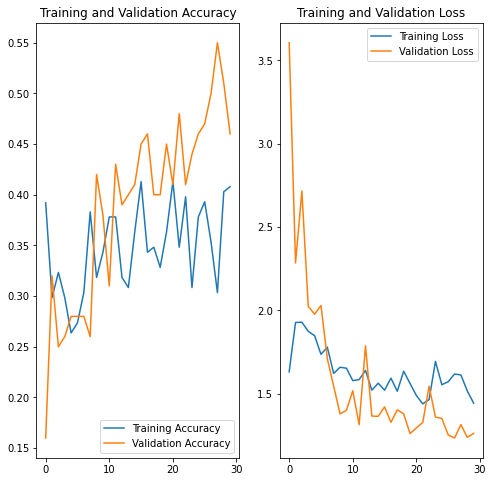

In [16]:
plot(history_conv3d)

# 2.Conv2D + GRU

In [17]:
model_Conv2DGRU = Sequential()

model_Conv2DGRU.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(frames,rows,cols,channel)))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(frames,rows,cols,channel)))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))

model_Conv2DGRU.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))

model_Conv2DGRU.add(TimeDistributed(Flatten()))

model_Conv2DGRU.add(GRU(128,kernel_regularizer=l2(0.01)))
model_Conv2DGRU.add(Dropout(0.2))

model_Conv2DGRU.add(Dense(128,activation='relu'))
model_Conv2DGRU.add(BatchNormalization())
model_Conv2DGRU.add(Dropout(0.5))
model_Conv2DGRU.add(Dense(64,activation='relu'))
model_Conv2DGRU.add(Dropout(0.25))
#model_Conv2DGRU.add(Dense(1, activation='sigmoid'))

model_Conv2DGRU.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
model_Conv2DGRU.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Conv2DGRU.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 10, 120, 120, 16)  0         
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 60, 60, 16)   2320      
 tributed)                                            

In [18]:
history_Conv2DGRU = model_Conv2DGRU.fit(train_generator, 
                                       steps_per_epoch=steps_per_epoch, 
                                       epochs=num_epochs, 
                                       verbose=1, 
                                       callbacks=callbacks_list, 
                                       validation_data=val_generator, 
                                       validation_steps=validation_steps, 
                                       class_weight=None,
                                       initial_epoch=0) 

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 4.3038 - categorical_accuracy: 0.2338
Epoch 00001: val_loss did not improve from 1.23297
67/67 [==============================] - 27s 357ms/step - loss: 4.3038 - categorical_accuracy: 0.2338 - val_loss: 3.3677 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 3.8033 - categorical_accuracy: 0.2537
Epoch 00002: val_loss did not improve from 1.23297
67/67 [==============================] - 23s 349ms/step - loss: 3.8033 - categorical_accuracy: 0.2537 - val_loss: 3.3670 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 3.4288 - categorical_accuracy: 0.2687
Epoch 00003: val_loss did not improve from 1.23297
67/67 [==============================] - 23s 354ms/step - loss: 3.4288 - categorical_accuracy: 0.2687 - val_loss: 3.6161 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 4/30
67/67 [====

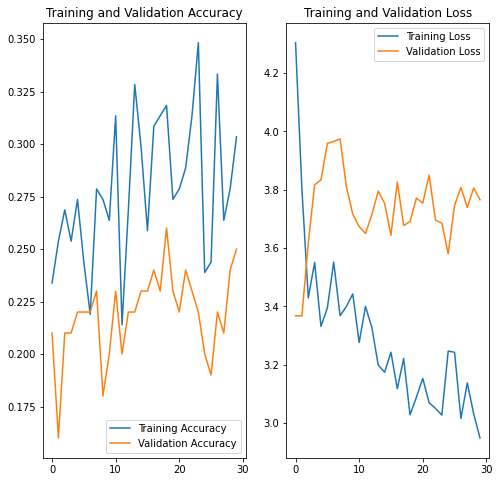

In [19]:
plot(history_Conv2DGRU)

# 3.Conv2D + LSTM

In [21]:
model_conv2DLSTM = Sequential()

model_conv2DLSTM.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(frames,rows,cols,channel)))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Flatten()))

model_conv2DLSTM.add(LSTM(256))
model_conv2DLSTM.add(Dropout(0.5))

model_conv2DLSTM.add(Dense(256,activation='relu'))
model_conv2DLSTM.add(Dropout(0.25))
model_conv2DLSTM.add(Dense(256,activation='relu'))
model_conv2DLSTM.add(Dropout(0.25))
model_conv2DLSTM.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam() #write your optimizer
model_conv2DLSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv2DLSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeDi  (None, 10, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 10, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 10, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 10, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 10, 60, 60, 32)  

In [22]:
history_conv2DLSTM = model_conv2DLSTM.fit(train_generator, 
                                       steps_per_epoch=steps_per_epoch, 
                                       epochs=num_epochs, 
                                       verbose=1, 
                                       callbacks=callbacks_list, 
                                       validation_data=val_generator, 
                                       validation_steps=validation_steps, 
                                       class_weight=None,
                                       initial_epoch=0) 

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.7492 - categorical_accuracy: 0.1741
Epoch 00001: val_loss did not improve from 1.23297
67/67 [==============================] - 27s 365ms/step - loss: 1.7492 - categorical_accuracy: 0.1741 - val_loss: 1.6177 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.6276 - categorical_accuracy: 0.3035
Epoch 00002: val_loss did not improve from 1.23297
67/67 [==============================] - 24s 359ms/step - loss: 1.6276 - categorical_accuracy: 0.3035 - val_loss: 1.6979 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.5569 - categorical_accuracy: 0.3134
Epoch 00003: val_loss did not improve from 1.23297
67/67 [==============================] - 23s 343ms/step - loss: 1.5569 - categorical_accuracy: 0.3134 - val_loss: 1.9643 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 4/30
67/67 [

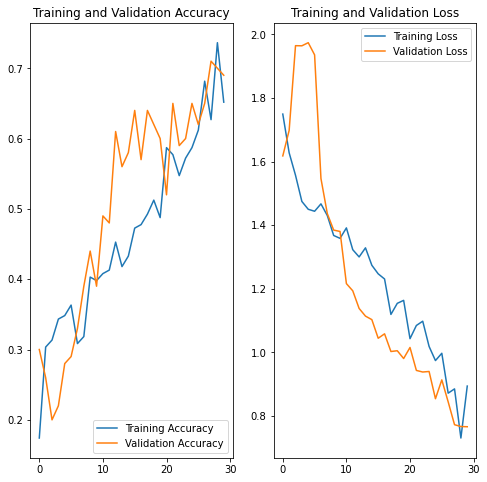

In [23]:
plot(history_conv2DLSTM)

# 4.Transfer Learning:MobileNet +LSTM

In [25]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model_transferLSTM = Sequential()
model_transferLSTM.add(TimeDistributed(mobilenet_transfer,input_shape=(10,120,120,3)))

for layer in model_transferLSTM.layers:
    layer.trainable = False

model_transferLSTM.add(TimeDistributed(BatchNormalization()))
model_transferLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
model_transferLSTM.add(TimeDistributed(Flatten()))

model_transferLSTM.add(LSTM(64))
model_transferLSTM.add(Dropout(.25))

model_transferLSTM.add(Dense(128,activation='relu'))
model_transferLSTM.add(Dropout(0.25))

model_transferLSTM.add(Dense(64,activation='relu'))
model_transferLSTM.add(Dropout(0.25))

model_transferLSTM.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model_transferLSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_transferLSTM.summary())

17235968/17225924 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 10, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 10, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 10, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 10, 1024)         0         
 stributed)                                                      
                                                       

In [26]:
history_transferLSTM = model_transferLSTM.fit(train_generator, 
                                       steps_per_epoch=steps_per_epoch, 
                                       epochs=num_epochs, 
                                       verbose=1, 
                                       callbacks=callbacks_list, 
                                       validation_data=val_generator, 
                                       validation_steps=validation_steps, 
                                       class_weight=None,
                                       workers=1,
                                       initial_epoch=0)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6195 - categorical_accuracy: 0.2886
Epoch 00001: val_loss did not improve from 0.76643
67/67 [==============================] - 27s 361ms/step - loss: 1.6195 - categorical_accuracy: 0.2886 - val_loss: 1.5294 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.5550 - categorical_accuracy: 0.3035
Epoch 00002: val_loss did not improve from 0.76643
67/67 [==============================] - 23s 346ms/step - loss: 1.5550 - categorical_accuracy: 0.3035 - val_loss: 1.3669 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.4734 - categorical_accuracy: 0.3731
Epoch 00003: val_loss did not improve from 0.76643
67/67 [==============================] - 23s 347ms/step - loss: 1.4734 - categorical_accuracy: 0.3731 - val_loss: 1.3047 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 4/30
67/67 [====

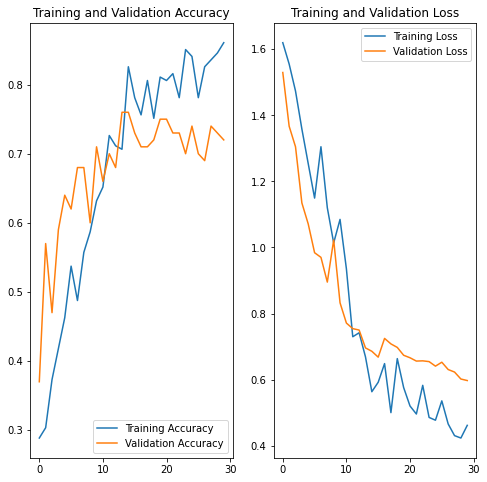

In [27]:
plot(history_transferLSTM)

# Observations

- *Superior Performance*: The Transfer Learning and LSTM model excels in gesture recognition.
- *High Accuracy*: Achieves 86.1% training accuracy and 74.0% validation accuracy.
- *Low Loss*: Exhibits a validation loss of 0.60.
- *Optimized*: Utilizes 297,733 parameters effectively.
- *Best Model*: Stands out as the most effective and optimized model among those evaluated.